# Porirua spatial analysis with slope

In [1]:
# Install support package and dependencies 
!pip install --upgrade -e ../.

# Ensure access to packge for imports
import sys
sys.path.append('../')

Obtaining file:///home/jovyan/work/osm/osmnx-catchments
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: osmcatch
    Found existing installation: osmcatch 0.0.1
    Uninstalling osmcatch-0.0.1:
      Successfully uninstalled osmcatch-0.0.1
  Running setup.py develop for osmcatch


## Get walk network and slope

We obtain the walk network from OpenStreetMaps using the `osmnx` and `osmnxcatch` Python libraries for the Porirua City using StatsNZ local authority boundary. The walk network is defined using the following osm tags and is extracted for a specified date for repeatability.

```
walk_highways = '["area"!~"yes"]["highway"]' + \
    '["highway"!~"motorway"]' + \
    '["highway"!~"motorway_junction"]' + \
    '["highway"!~"traffic_signals"]["highway"!~"give_way"]' + \
    '["foot"!~"no"]' + \
    '["sidewalk"!~"no|separate"]["area"!~"yes"]'
walk_footways = '["area"!~"yes"]["footway"]'
```

NB: The osm walking network and tags have been reviewed as part of this process. THe areas around Porirua city centre, Porirua Station and Kenepuru Station have been reviewed to date and updated to ensure the above tags return an accurate walk network. 


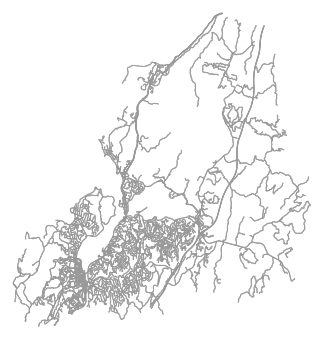

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [2]:
from osmcatch import network
import osmnx as ox

# Define point within Porirua
access_point = (-41.1377659, 174.8432213) # Porirua Station Entrance 1

# Get local authority walk network
G = network.get_osm_walk_network(access_point, 
                                 snapshot_date="2021-06-01T12:00:00Z",
                                 return_local_authority_network=True)

# Optional, plot network
ox.plot_graph(G, bgcolor="white", node_size=0, figsize=(6,6))

Once we get the walk network we want to determine the slopes which are to be used to adjust walk speeds. We used the LINZ [Wellington region DEM 2013/14](https://data.linz.govt.nz/layer/53621-wellington-lidar-1m-dem-2013-2014/) dataset for this purpose. Due to the number of data points there is no suiable API to query the DEM data directly. The DEM data was downloaded for area `Territorial Authorities = "Porirua City"` using `crs=2193` and saved to a local folder `/spatial_data/linz_dem_2013_porirua`. This is not included in version control as around 700MB in size.

The following processes the raster DEM data and udpates the Porirua graph generated above.

In [3]:
from osmcatch import elevation
from pathlib import Path

# Path to raster data 
dem_path = 'spatial_data/linz_dem_2013_porirua/'
dem_path = Path.home().joinpath(Path(dem_path))

# Process all tiles adding elevations to graph
dem_tile_paths = list(dem_path.glob("DEM*.tif"))
G2 = elevation.add_elevations_to_graph(G, 
                                       raster_path=dem_tile_paths,
                                       raster_crs='epsg:2193')

walk = network.WalkNetwork(G2)


The followings show a histogram of slope (rise over run) on left and elevation (m) on right. The slope is a log scale as dominated by near zero slope. The elevation histogram shows most nodes have a near zero elevation (above sea level). 

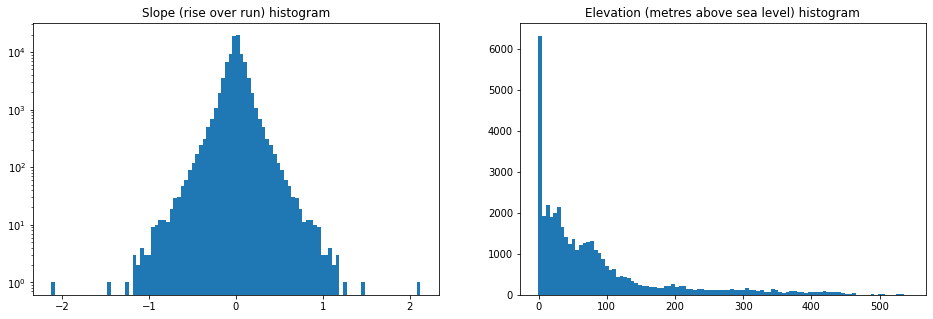

In [4]:
import matplotlib.pyplot as plt

bins = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

data = walk.edges['grade'].dropna()
_ = ax1.hist(data, bins=bins, log=True)
_ = ax1.set_title('Slope (rise over run) histogram')

data = walk.nodes['elevation'].dropna()
_ = ax2.hist(data, bins=bins)
_ = ax2.set_title('Elevation (metres above sea level) histogram')


We do a manual calculation to check how the gradient is calculated.

In [82]:
y1 = walk.nodes.loc[170503846,'elevation']
y2 = walk.nodes.loc[6095246412,'elevation']
run, grade = walk.edges.loc[(170503846, 6095246412, 0), ('length', 'grade')]

import math
# calc gradient from points to check result
calc_grade = round((p2-p1)/l1, 3) 

# convert to degrees
calc_deg = math.degrees(math.atan(calc_grade))

assert grade == calc_grade

## Impact of slope on walk speeds

The impact of slope on walk speeds is not clearly understood. There are some empirical studies although these focus mainly on hiking [Cambel et al (2019) Using crowdsourced fitness tracker data to model the relationship between slope and travel rates](https://doi.org/10.1016/j.apgeog.2019.03.008) with the impact of slope largely governed by rules-of-thumb such as Tobler's hiking function (Campbell et al). There is also a body of health research looking at areas such as impact of speed on ambulatory motion [Koo S, Park MS, Chung CY, Yoon JS, Park C, Lee KM 2019) Effects of walking speed and slope on pedobarographic findings in young healthy adults](https://pubmed.ncbi.nlm.nih.gov/31454402/).

Waka Kotahi NZ Transport Agency are currently updating the pedestrian planning and design guide. It is unknown whether this will change the assumptions regarding walk speeds. The [NZ Transport Agency (2009) Pedestrian planning and design guide](https://www.nzta.govt.nz/resources/pedestrian-planning-guide/) states the following regarding speeds (section 3.4):

```
The vast majority of people walk at speeds between 0.8 metres per second (m/s) and
1.8 m/s (2.9 kilometres per hour (km/h) and 6.5 km/h) [139]. A fit, healthy adult will
generally travel at a mean speed of 1.5 m/s (15th percentile (15%ile): 1.3 m/s), and
the aged and those with mobility impairments travel more slowly, at around 1.2 m/s
(15%ile: 1.0 m/s)
```

The following references are cited in teh planning and design guide but have not been reviewed as sit behind a paywall.
- [Knoblauch, R. L, M. T. Pietrucha, and M. Nitzburg (1996) *Field studies of pedestrian walking speed and start-up time*. Transportation Research Record 1538.](https://doi.org/10.1177%2F0361198196153800104)
- [Milazzo, J. S., N. M. Rouphail, J. E. Hummer, and D. P. Allen (1999) *Quality of Service for Uninterrupted-Flow Pedestrian Facilities in Highway Capacity Manual 2000*](https://doi.org/10.3141%2F1678-03)

The [Transportation Research Board (2000) *Highway capacity manual*](http://www.trb.org/Main/Blurbs/Highway_Capacity_Manual_2010_HCM2010_164718.aspx) states that the free-flow speed of pedestrians on a footpath is approximalye 1.5 m/s with a a uphill gradient of 10% or more reducing walking speed by 0.1 m/s (page 18-1). The 1.5 m/s speed is an often quoted rule of thumb with 1.5 m/s converting to 5.4 km/h and a change of 0.1 m/s converting to 0.36 km/h. More recent versions of the *Highway capacity manual* have not been reviewed as sitting behind a paywall. 

The most comprehensive and recent look at the impact of slope on walk speed is [Campbell et al (2019) Using crowdsourced fitness tracker data to model the relationship between slope and travel rates](https://doi.org/10.1016/j.apgeog.2019.03.008). This paper looks at a number of gradient/walk speed functions and recommends the *Lorentz* formulation using the 5th percentile. The formulation is as follows, but unfortunately the paper does not recommend parameter values:

$$
  V_{Lorentz} = c \left( \frac{1}{\pi b \left[1 + \left( \frac{\theta - a}{b} \right) ^2 \right] } \right) + d + e \theta
$$ (Lorentz formulation)

where

- $V$ represents travel rate in m/s
- $\theta$ represents slope in degrees
- $a$ represents a curve-centering term (akin to the mean of the distribution)
- $b$ represents a curve-width-widening term (akin to the standard deviation of the distribution)
- $c$ is an additional multiplicative term as travel rate data are bounded by [0,10]
- $d$ is additive term requires as none of the travel rate percentiles reach zero
- $e$ is a final slope-dependent multiplicative term allowing for anisotropy in uphill and downhill travel rates

Given the lack of evidence on paramter values a simplified formulation is required.

Other references
- [Finnis & Walton (nd) *Field observations of factors influencing walking speeds*. New Zealand]
- [Joaquín Márquez-Pérez, Ismael Vallejo-Villalta & José I. Álvarez-Francoso (2017) Estimated travel time for walking trails in natural areas, Geografisk Tidsskrift-Danish Journal of Geography, 117:1, 53-62, DOI: 10.1080/00167223.2017.1316212](https://www.tandfonline.com/doi/full/10.1080/00167223.2017.1316212)
- [James G. Colclough & Eric Owens (2010) Mapping Pedestrian Journey Times using a Network-based GIS Model, Journal of Maps, 6:1, 230-239, DOI: 10.4113/jom.2010.1075](https://www.tandfonline.com/doi/abs/10.4113/jom.2010.1075)
- [Irmischer, I., & Clarke, K. (2018). Measuring and modeling the speed of human navigation. CARTOGRAPHY AND GEOGRAPHIC INFORMATION SCIENCE, 45(2), 177-186](http://dx.doi.org/10.1080/15230406.2017.1292150)

Irmischer & Clarke (2017) seems likely candidate for a formula. THe following being the Irmischer model of on-road navigation speed for males

$$
  Speed_{m/s} = 0.11 + e^\left(\frac{-(Slope + 5)^2}{2 * 30^2}\right)
$$ (Irmischer formulation)

where

- $Slope = \Delta elevation / \Delta distance$

The Irmischer formulation is derived from a study of 200 military personel within a rural setting where the terrain is hilly and wooded. This is likley not directly applicable to the urban environment, although the impact of slope on the on-road navigation formulation is possibly generalisable. It is proposed that the Irmischer formulation be used by adjusted to 

modeled the speed of movement of human beings engaged in foot-based navigation in wooded environments with varied terrain, using military personal. This .


[1.2066482778577163]

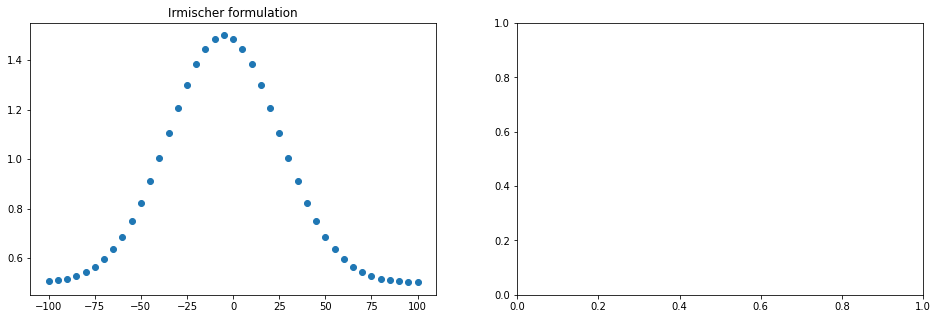

In [176]:
def speed(gradients, standard_speed=1.11): 
    """
    Return speed based on slope (rise over run)
    
    Uses formulation and parameter values from [Irmischer, I., & Clarke, K. (2018). 
    Measuring and modeling the speed of human navigation. CARTOGRAPHY AND 
    GEOGRAPHIC INFORMATION SCIENCE, 45(2), 177-186]
    (http://dx.doi.org/10.1080/15230406.2017.1292150).
    
    Parameters
    ----------
    gradients : list or series
        list or series of gradients, as a percentage i.e. rise over run.
    standard_speed : decimal
        standard walk speed that will be adjusted by gradient, default 4.8km/h. 
        
    Returns
    -------
    speed : List of decimal
        list of speeds adjusted by slope
    
    """
    
    slope = [slope] if type(slope) == int else slope
    
    s = [(standard_speed - 1) + math.exp(-(s + 5)**2 / (2 * 30**2)) for s in slope]

    return s

s = range(-100,105,5) 
v = speed(s, standard_speed=1.5)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

_ = ax1.scatter(x=s, y=v)
_ = ax1.set_title('Irmischer formulation')

speed(20, standard_speed=1.5)

$$
  Speed_{m/s} = 0.11 + e^\left(\frac{-(Slope + 5)^2}{62}\right)
$$ (Irmischer formulation)

In [170]:
5/10

0.5

```{math}
:label: my_label
w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1}
```